In [1]:
#Imports
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2024-02-10 16:06:29.554066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Download asset data
df = yf.download(tickers="AAPL", start='2010-01-01', end='2023-12-31')

#calculatre technical indicators
df['MA'] = ta.ema(df['Close'], length=20)
df['rsi'] = ta.rsi(df['Close'], length=14)
df['coppock'] = ta.coppock(df['Close'], length=12)
df['returns'] = df['Close'].pct_change(-1) * 100 * -1
df['forecast_tommorrow'] = np.where(df['returns'] > 0,
                                   1,
                                   0) #1 is for UP and 0 is for down

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA,rsi,coppock,returns,forecast_tommorrow
Date,,,,,,,,,,,
2010-01-04 00:00:00-05:00,7.622500,7.660714,7.585000,7.643214,6.470740,493729600,NaN,NaN,NaN,0.172595,1
2010-01-05 00:00:00-05:00,7.664286,7.699643,7.616071,7.656429,6.481928,601904800,NaN,NaN,NaN,-1.616343,0
2010-01-06 00:00:00-05:00,7.656429,7.686786,7.526786,7.534643,6.378824,552160000,NaN,NaN,NaN,-0.185213,0
2010-01-07 00:00:00-05:00,7.562500,7.571429,7.466071,7.520714,6.367032,477131200,NaN,NaN,NaN,0.660442,1
2010-01-08 00:00:00-05:00,7.510714,7.571429,7.466429,7.570714,6.409362,447610800,NaN,NaN,NaN,-0.889999,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,193.330404,54.609714,5.026601,-0.284902,0
2023-12-26 00:00:00-05:00,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,193.303699,53.026883,3.980161,0.051768,1
2023-12-27 00:00:00-05:00,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,193.289060,53.291938,3.311362,0.222134,1


In [3]:
#drop NAs
df = df.dropna()
df

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,coppock,returns,forecast_tommorrow
Date,,,,,,,,,,,
2010-02-09 00:00:00-05:00,7.015000,7.053571,6.955357,7.006786,5.931941,632886800,7.207269,42.054113,-12.137974,-0.548386,0
2010-02-10 00:00:00-05:00,6.996071,7.021429,6.937857,6.968571,5.899589,370361600,7.184536,41.000213,-12.181045,1.786883,1
2010-02-11 00:00:00-05:00,6.960000,7.133929,6.930714,7.095357,6.006925,550345600,7.176043,45.848891,-11.032437,0.853385,1
2010-02-12 00:00:00-05:00,7.075357,7.201429,6.982143,7.156429,6.058628,655468800,7.174175,48.063030,-9.429613,1.484760,1
2010-02-16 00:00:00-05:00,7.212143,7.274643,7.197143,7.264286,6.149940,543737600,7.182757,51.810537,-7.010931,-0.419646,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00-05:00,196.100006,197.080002,193.500000,194.679993,194.431885,46482500,193.302025,57.752982,5.560316,-0.557844,0
2023-12-22 00:00:00-05:00,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,193.330404,54.609714,5.026601,-0.284902,0
2023-12-26 00:00:00-05:00,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,193.303699,53.026883,3.980161,0.051768,1


In [4]:
#Normalize data for each column
df_normalized = df.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
for col in df_normalized.columns:
        df_normalized[col] = scaler.fit_transform(df_normalized[col].values.reshape(-1, 1))
        
df_normalized

,Open,High,Low,Close,Adj Close,Volume,MA,rsi,coppock,returns,forecast_tommorrow
Date,,,,,,,,,,,
2010-02-09 00:00:00-05:00,0.000288,0.000167,0.000130,0.000200,0.000169,0.327870,0.000178,0.303114,0.280928,0.558286,0.0
2010-02-10 00:00:00-05:00,0.000189,0.000000,0.000038,0.000000,0.000000,0.186496,0.000056,0.287923,0.280278,0.649998,1.0
2010-02-11 00:00:00-05:00,0.000000,0.000584,0.000000,0.000663,0.000559,0.283420,0.000010,0.357811,0.297620,0.613337,1.0
2010-02-12 00:00:00-05:00,0.000604,0.000935,0.000271,0.000983,0.000829,0.340031,0.000000,0.389726,0.321820,0.638133,1.0
2010-02-16 00:00:00-05:00,0.001320,0.001315,0.001402,0.001547,0.001304,0.279862,0.000046,0.443742,0.358338,0.563342,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21 00:00:00-05:00,0.989951,0.986812,0.981586,0.982055,0.982154,0.012081,0.999848,0.529396,0.548143,0.557914,0.0
2023-12-22 00:00:00-05:00,0.985135,0.978141,0.978797,0.976405,0.976535,0.007041,1.000000,0.484089,0.540085,0.568634,0.0
2023-12-26 00:00:00-05:00,0.976918,0.970249,0.978061,0.973527,0.973674,0.002623,0.999857,0.461275,0.524285,0.581856,1.0


In [5]:
def LSTM_create_sequences(data, sequence_lenght, target_col_index):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_lenght):
        # Select sequence length rows for all columns
        seq = data.iloc[i:i+sequence_lenght, :-1] # -1 to leave y out
        label = data.iloc[i+sequence_lenght, target_col_index]
        
        sequences.append(seq.values)
        labels.append(label)

    return np.array(sequences), np.array(labels)

In [6]:
#Define x and y using LSTM_create_sequences
X, y = LSTM_create_sequences(data=df, 
                            sequence_lenght=10,
                            target_col_index=df.columns.get_loc("forecast_tommorrow"))

In [7]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.75) #75% of data to train model
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# Reshape the data for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 10)) #last num is the num of cols
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 10))

In [9]:
X_train

array([[[  7.01499987,   7.05357122,   6.95535707, ...,  42.05411338,
         -12.13797434,  -0.54838621],
        [  6.99607086,   7.02142906,   6.93785715, ...,  41.00021296,
         -12.18104479,   1.7868834 ],
        [  6.96000004,   7.13392878,   6.93071413, ...,  45.84889082,
         -11.03243722,   0.85338476],
        ...,
        [  7.20928621,   7.25714302,   7.18249989, ...,  49.40512512,
          -1.19278657,  -0.62369122],
        [  7.22642899,   7.23214293,   7.11392879, ...,  47.61744215,
           0.72515274,  -1.70506284],
        [  7.14285707,   7.19035721,   6.9896431 , ...,  43.10267277,
           1.48615526,   1.79408721]],

       [[  6.99607086,   7.02142906,   6.93785715, ...,  41.00021296,
         -12.18104479,   1.7868834 ],
        [  6.96000004,   7.13392878,   6.93071413, ...,  45.84889082,
         -11.03243722,   0.85338476],
        [  7.07535696,   7.20142889,   6.98214293, ...,  48.06303019,
          -9.42961253,   1.48476019],
        ...,


In [10]:
"""USE FOR REGRESSION PREDICTIONS

# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 9)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')"""

"USE FOR REGRESSION PREDICTIONS\n\n# Create the LSTM model\nmodel = Sequential()\nmodel.add(LSTM(units=50, input_shape=(X_train.shape[1], 9)))\nmodel.add(Dense(units=1))\nmodel.compile(optimizer='adam', loss='mean_squared_error')"

In [20]:
#For binary predictions
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 10))) #last num is the numb of cols
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
82/82 [==============================] - 2s 3ms/step - loss: 0.7042 - accuracy: 0.4732
Epoch 2/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5298
Epoch 3/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5298
Epoch 4/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5298
Epoch 5/50
82/82 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5298
Epoch 6/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.5298
Epoch 7/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5298
Epoch 8/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5298
Epoch 9/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5298
Epoch 10/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6919 - accuracy: 0.5298
Epoch 11/50
82/82 [

In [22]:
# Make predictions on the test set
predictions = model.predict(X_test)
#binary_predictions = (predictions > 0.5).astype(int)

28/28 [==============================] - 0s 1ms/step


In [23]:
realAndPred = pd.DataFrame({'y_test': y_test})
realAndPred['predict'] = predictions
realAndPred.head(50)

,y_test,predict
0,1,0.522746
1,0,0.522746
2,0,0.522746
3,1,0.522746
4,0,0.522746
5,1,0.522746
6,0,0.522746
7,0,0.522746
8,1,0.522746
9,0,0.522746


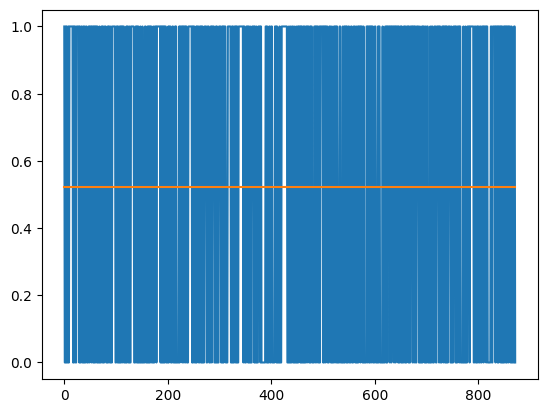

In [15]:
plt.plot(realAndPred['y_test'])
plt.plot(realAndPred['predict'])